# 03 - t-SNE, UMAP, and Clustering

Build low-dimensional embeddings (t-SNE and UMAP) from the processed PCA scores, inspect structure, and persist the results for later clinical association notebooks.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "README.md").exists():
            return candidate
    raise FileNotFoundError("Unable to locate repository root (README.md not found)")


PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import ProjectConfig
from src.data_loading import load_expression_manifest, load_pca_scores
from src.plotting import plot_pca_categorical, plot_pca_continuous, scatter_embedding

config = ProjectConfig()
PROCESSED_DATA_DIR = config.processed_data_dir
PCA_PATH = PROCESSED_DATA_DIR / "tcga_brca_pca_scores.tsv.gz"
PCA_PATH


PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_pca_scores.tsv.gz')

## Load PCA scores

Use the PCA embedding generated in Notebook 02 as the starting space for downstream manifold learning.


In [2]:
pca_df = load_pca_scores()
pca_df.head()


PC1        PC2        PC3  \
eddd285e-a946-4e4e-a21d-6e84ed397594  66.881381  10.464202 -17.882775   
4aac7c40-db6b-4648-a82a-7bf397de913a  32.429013  -9.957598  40.264804   
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -87.738503  39.949205  46.913361   
20d25e27-b509-45eb-a734-9b8d6a40c632  58.511724   9.020735 -12.361333   
678ba111-3b01-49b7-83d9-165ef0288a34  91.537910  34.798539  -5.758935   

                                            PC4        PC5        PC6  \
eddd285e-a946-4e4e-a21d-6e84ed397594  24.450980 -34.534961  12.962275   
4aac7c40-db6b-4648-a82a-7bf397de913a  42.590246 -21.292736  55.190396   
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -59.784433   6.412864 -62.221974   
20d25e27-b509-45eb-a734-9b8d6a40c632  47.892200  76.432903 -41.735964   
678ba111-3b01-49b7-83d9-165ef0288a34  18.729015 -18.983191  20.311883   

                                            PC7        PC8        PC9  \
eddd285e-a946-4e4e-a21d-6e84ed397594  -5.833964  27.902865  25.287797   
4aac7c40-db6b-4648-a82a-7bf397de913a -33.987849   3.572891   0.974376   
cdc523d2-da82-4a3d-a97e-9745c8a802d1  -7.556203  22.414156  21.887043   
20d25e27-b509-45eb-a734-9b8d6a40c632  17.798618  19.477678  13.830445   
678ba111-3b01-49b7-83d9-165ef0288a34 -31.539405  23.071203   5.154782   

                                           PC10  ...       PC41      PC42  \
eddd285e-a946-4e4e-a21d-6e84ed397594  -1.656168  ...   4.840135 -9.810804   
4aac7c40-db6b-4648-a82a-7bf397de913a  20.818672  ...  -1.828826 -6.862730   
cdc523d2-da82-4a3d-a97e-9745c8a802d1  -7.342581  ...   7.690612 -6.034682   
20d25e27-b509-45eb-a734-9b8d6a40c632 -26.064546  ...  15.193230  3.339026   
678ba111-3b01-49b7-83d9-165ef0288a34   2.454015  ...  13.733020 -3.224252   

                                           PC43      PC44       PC45  \
eddd285e-a946-4e4e-a21d-6e84ed397594   5.326876 -1.743993  10.895772   
4aac7c40-db6b-4648-a82a-7bf397de913a   4.830118 -9.513705   6.407914   
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -29.825285 -0.573876  24.762176   
20d25e27-b509-45eb-a734-9b8d6a40c632   4.397652 -0.649963   0.078738   
678ba111-3b01-49b7-83d9-165ef0288a34   9.158292 -0.976767   1.603692   

                                           PC46       PC47      PC48  \
eddd285e-a946-4e4e-a21d-6e84ed397594  -1.771303   2.014357 -0.877309   
4aac7c40-db6b-4648-a82a-7bf397de913a  -6.499774  -4.540029 -2.748677   
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -20.917960  -2.107538  3.631840   
20d25e27-b509-45eb-a734-9b8d6a40c632   8.589395   5.984064  2.373127   
678ba111-3b01-49b7-83d9-165ef0288a34  -1.013049 -11.823112 -5.078651   

                                           PC49      PC50  
eddd285e-a946-4e4e-a21d-6e84ed397594   0.184497 -3.534204  
4aac7c40-db6b-4648-a82a-7bf397de913a  -3.104844  1.421216  
cdc523d2-da82-4a3d-a97e-9745c8a802d1  -2.675258  8.189914  
20d25e27-b509-45eb-a734-9b8d6a40c632   4.694300 -4.044868  
678ba111-3b01-49b7-83d9-165ef0288a34  10.120465 -7.915902  

[5 rows x 50 columns]

In [3]:
expression_index_with_biospecimen = load_expression_manifest()

biospecimen_fields = [
    "sample_type",
    "tumor_descriptor",
    "specimen_type",
    "preservation_method",
    "tissue_type",
    "days_to_collection",
    "analyte_type",
    "aliquot_quantity",
    "aliquot_volume",
    "concentration",
    "normal_tumor_genotype_snp_match",
    "source_center",
]
lookup = (
    expression_index_with_biospecimen.drop_duplicates(subset=["entity_id"])
    .set_index("entity_id")
    .copy()
)
missing_fields = [col for col in biospecimen_fields if col not in lookup.columns]
for col in missing_fields:
    lookup[col] = pd.NA
pca_with_biospecimen = pca_df.join(lookup[biospecimen_fields], how="left")
if missing_fields:
    print(f"Missing biospecimen fields in manifest: {', '.join(missing_fields)}")
pca_with_biospecimen.head()


PC1        PC2        PC3  \
eddd285e-a946-4e4e-a21d-6e84ed397594  66.881381  10.464202 -17.882775   
4aac7c40-db6b-4648-a82a-7bf397de913a  32.429013  -9.957598  40.264804   
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -87.738503  39.949205  46.913361   
20d25e27-b509-45eb-a734-9b8d6a40c632  58.511724   9.020735 -12.361333   
678ba111-3b01-49b7-83d9-165ef0288a34  91.537910  34.798539  -5.758935   

                                            PC4        PC5        PC6  \
eddd285e-a946-4e4e-a21d-6e84ed397594  24.450980 -34.534961  12.962275   
4aac7c40-db6b-4648-a82a-7bf397de913a  42.590246 -21.292736  55.190396   
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -59.784433   6.412864 -62.221974   
20d25e27-b509-45eb-a734-9b8d6a40c632  47.892200  76.432903 -41.735964   
678ba111-3b01-49b7-83d9-165ef0288a34  18.729015 -18.983191  20.311883   

                                            PC7        PC8        PC9  \
eddd285e-a946-4e4e-a21d-6e84ed397594  -5.833964  27.902865  25.287797   
4aac7c40-db6b-4648-a82a-7bf397de913a -33.987849   3.572891   0.974376   
cdc523d2-da82-4a3d-a97e-9745c8a802d1  -7.556203  22.414156  21.887043   
20d25e27-b509-45eb-a734-9b8d6a40c632  17.798618  19.477678  13.830445   
678ba111-3b01-49b7-83d9-165ef0288a34 -31.539405  23.071203   5.154782   

                                           PC10  ...  specimen_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594  -1.656168  ...   Solid Tissue   
4aac7c40-db6b-4648-a82a-7bf397de913a  20.818672  ...   Solid Tissue   
cdc523d2-da82-4a3d-a97e-9745c8a802d1  -7.342581  ...   Solid Tissue   
20d25e27-b509-45eb-a734-9b8d6a40c632 -26.064546  ...   Solid Tissue   
678ba111-3b01-49b7-83d9-165ef0288a34   2.454015  ...   Solid Tissue   

                                      preservation_method  tissue_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594              Unknown        Tumor   
4aac7c40-db6b-4648-a82a-7bf397de913a              Unknown        Tumor   
cdc523d2-da82-4a3d-a97e-9745c8a802d1              Unknown        Tumor   
20d25e27-b509-45eb-a734-9b8d6a40c632              Unknown        Tumor   
678ba111-3b01-49b7-83d9-165ef0288a34                  OCT        Tumor   

                                      days_to_collection  analyte_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594               193.0           RNA   
4aac7c40-db6b-4648-a82a-7bf397de913a                57.0           RNA   
cdc523d2-da82-4a3d-a97e-9745c8a802d1                70.0           RNA   
20d25e27-b509-45eb-a734-9b8d6a40c632               796.0           RNA   
678ba111-3b01-49b7-83d9-165ef0288a34                80.0           RNA   

                                      aliquot_quantity  aliquot_volume  \
eddd285e-a946-4e4e-a21d-6e84ed397594              4.27            26.7   
4aac7c40-db6b-4648-a82a-7bf397de913a              4.27            26.7   
cdc523d2-da82-4a3d-a97e-9745c8a802d1              1.95            13.0   
20d25e27-b509-45eb-a734-9b8d6a40c632              2.08            13.0   
678ba111-3b01-49b7-83d9-165ef0288a34              4.27            26.7   

                                      concentration  \
eddd285e-a946-4e4e-a21d-6e84ed397594           0.16   
4aac7c40-db6b-4648-a82a-7bf397de913a           0.16   
cdc523d2-da82-4a3d-a97e-9745c8a802d1           0.15   
20d25e27-b509-45eb-a734-9b8d6a40c632           0.16   
678ba111-3b01-49b7-83d9-165ef0288a34           0.16   

                                      normal_tumor_genotype_snp_match  \
eddd285e-a946-4e4e-a21d-6e84ed397594                              Yes   
4aac7c40-db6b-4648-a82a-7bf397de913a                              Yes   
cdc523d2-da82-4a3d-a97e-9745c8a802d1                              Yes   
20d25e27-b509-45eb-a734-9b8d6a40c632                              Yes   
678ba111-3b01-49b7-83d9-165ef0288a34                              Yes   

                                      source_center  
eddd285e-a946-4e4e-a21d-6e84ed397594             23  
4aac7c40-db6b-4648-a82a-7bf397de913a             23  
cdc523d2-da82-4a3d-a97e-9745c8a80

## t-SNE embedding

Fit t-SNE on the PCA representation (50 dims). Feel free to adjust perplexity/learning rate to taste.


In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=35,
    learning_rate="auto",
    init="pca",
    metric="euclidean",
    random_state=42,
)
tsne_embedding = tsne.fit_transform(pca_df)

tsne_df = pd.DataFrame(tsne_embedding, index=pca_df.index, columns=["tSNE1", "tSNE2"])
tsne_df.head()

tSNE1      tSNE2
eddd285e-a946-4e4e-a21d-6e84ed397594  19.154497  -5.283939
4aac7c40-db6b-4648-a82a-7bf397de913a  10.476553  -9.005371
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -29.851149  10.312124
20d25e27-b509-45eb-a734-9b8d6a40c632   5.417372 -21.869778
678ba111-3b01-49b7-83d9-165ef0288a34  26.084085 -12.826666

In [5]:
tsne_with_biospecimen = tsne_df.join(lookup[biospecimen_fields], how="left")
tsne_with_biospecimen.head()


tSNE1      tSNE2    sample_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594  19.154497  -5.283939  Primary Tumor   
4aac7c40-db6b-4648-a82a-7bf397de913a  10.476553  -9.005371  Primary Tumor   
cdc523d2-da82-4a3d-a97e-9745c8a802d1 -29.851149  10.312124  Primary Tumor   
20d25e27-b509-45eb-a734-9b8d6a40c632   5.417372 -21.869778  Primary Tumor   
678ba111-3b01-49b7-83d9-165ef0288a34  26.084085 -12.826666  Primary Tumor   

                                     tumor_descriptor specimen_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594          Primary  Solid Tissue   
4aac7c40-db6b-4648-a82a-7bf397de913a          Primary  Solid Tissue   
cdc523d2-da82-4a3d-a97e-9745c8a802d1          Primary  Solid Tissue   
20d25e27-b509-45eb-a734-9b8d6a40c632          Primary  Solid Tissue   
678ba111-3b01-49b7-83d9-165ef0288a34          Primary  Solid Tissue   

                                     preservation_method tissue_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594             Unknown       Tumor   
4aac7c40-db6b-4648-a82a-7bf397de913a             Unknown       Tumor   
cdc523d2-da82-4a3d-a97e-9745c8a802d1             Unknown       Tumor   
20d25e27-b509-45eb-a734-9b8d6a40c632             Unknown       Tumor   
678ba111-3b01-49b7-83d9-165ef0288a34                 OCT       Tumor   

                                      days_to_collection analyte_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594               193.0          RNA   
4aac7c40-db6b-4648-a82a-7bf397de913a                57.0          RNA   
cdc523d2-da82-4a3d-a97e-9745c8a802d1                70.0          RNA   
20d25e27-b509-45eb-a734-9b8d6a40c632               796.0          RNA   
678ba111-3b01-49b7-83d9-165ef0288a34                80.0          RNA   

                                      aliquot_quantity  aliquot_volume  \
eddd285e-a946-4e4e-a21d-6e84ed397594              4.27            26.7   
4aac7c40-db6b-4648-a82a-7bf397de913a              4.27            26.7   
cdc523d2-da82-4a3d-a97e-9745c8a802d1              1.95            13.0   
20d25e27-b509-45eb-a734-9b8d6a40c632              2.08            13.0   
678ba111-3b01-49b7-83d9-165ef0288a34              4.27            26.7   

                                      concentration  \
eddd285e-a946-4e4e-a21d-6e84ed397594           0.16   
4aac7c40-db6b-4648-a82a-7bf397de913a           0.16   
cdc523d2-da82-4a3d-a97e-9745c8a802d1           0.15   
20d25e27-b509-45eb-a734-9b8d6a40c632           0.16   
678ba111-3b01-49b7-83d9-165ef0288a34           0.16   

                                     normal_tumor_genotype_snp_match  \
eddd285e-a946-4e4e-a21d-6e84ed397594                             Yes   
4aac7c40-db6b-4648-a82a-7bf397de913a                             Yes   
cdc523d2-da82-4a3d-a97e-9745c8a802d1                             Yes   
20d25e27-b509-45eb-a734-9b8d6a40c632                             Yes   
678ba111-3b01-49b7-83d9-165ef0288a34                             Yes   

                                      source_center  
eddd285e-a946-4e4e-a21d-6e84ed397594             23  
4aac7c40-db6b-4648-a82a-7bf397de913a             23  
cdc523d2-da82-4a3d-a97e-9745c8a802d1             23  
20d25e27-b509-45eb-a734-9b8d6a40c632             23  
678ba111-3b01-49b7-83d9-165ef0288a34             23

## t-SNE colored by biospecimen categorical labels
### 1. Sample type
### 2. Preservation method
### 3. Tumor descriptor


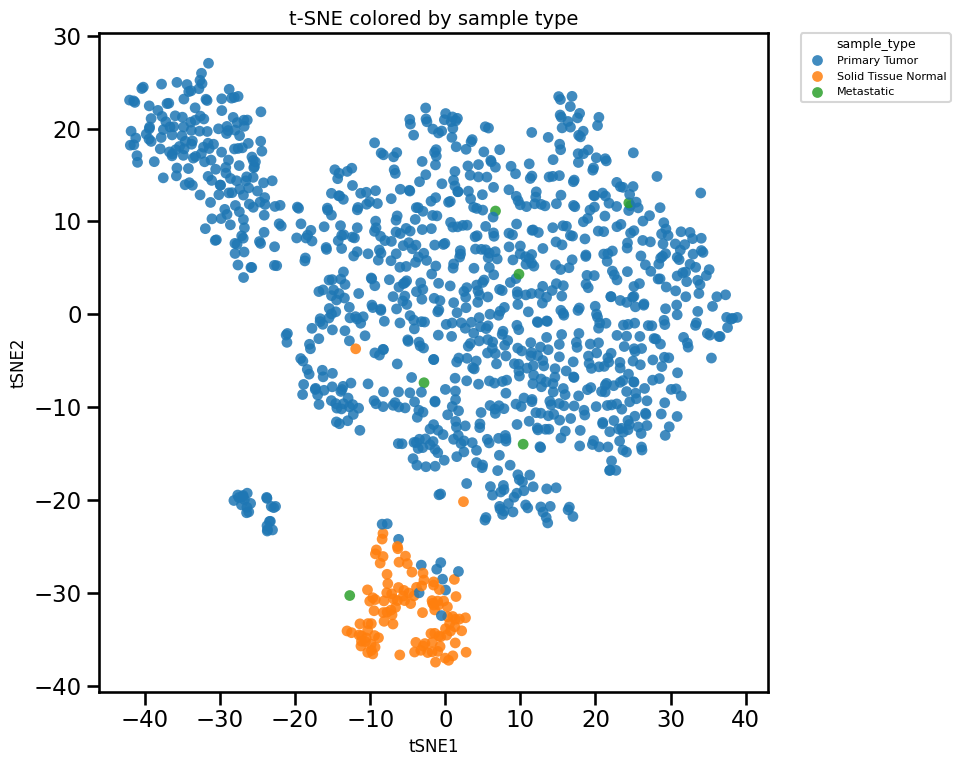

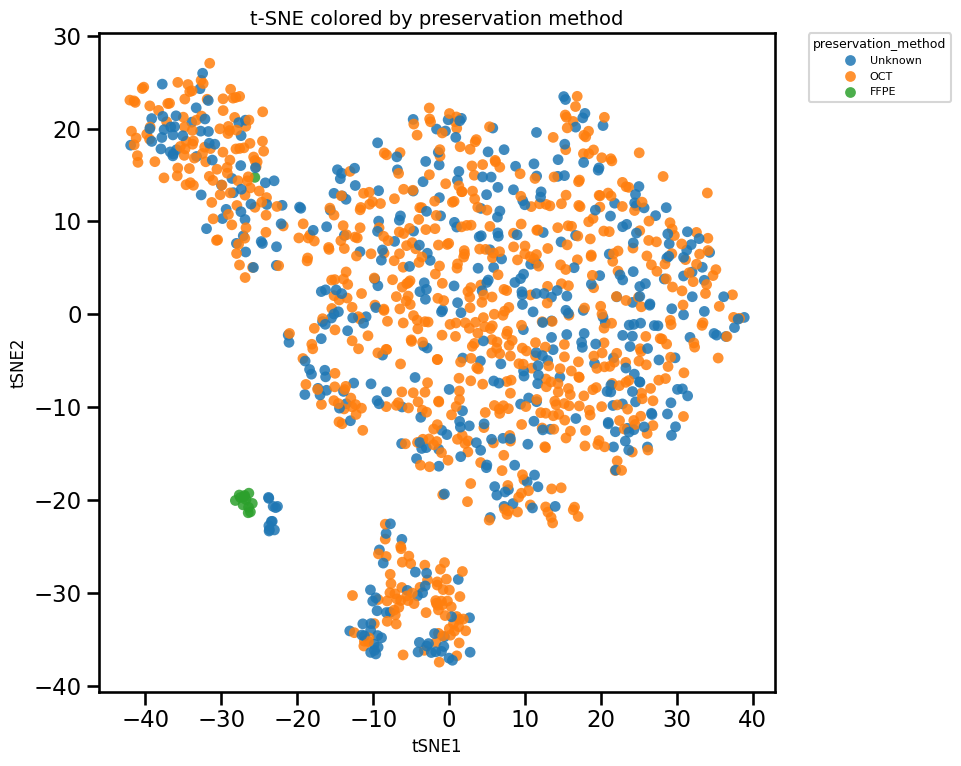

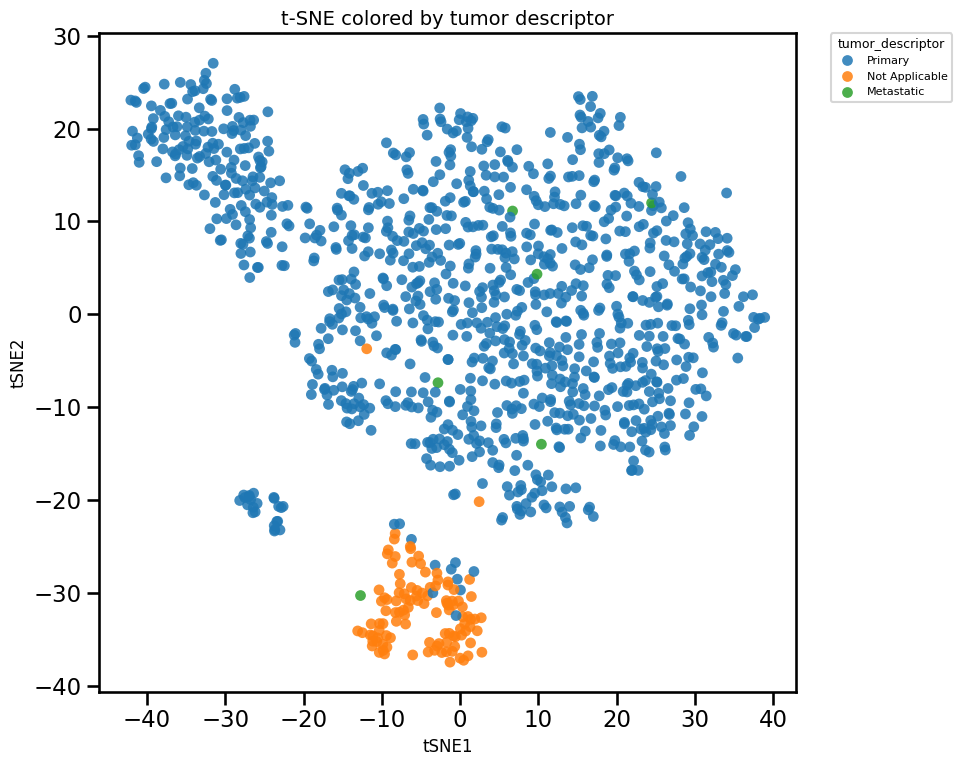

In [6]:
plot_pca_categorical(tsne_with_biospecimen, x="tSNE1", y="tSNE2", hue_col="sample_type", title="t-SNE colored by sample type")
plot_pca_categorical(tsne_with_biospecimen, x="tSNE1", y="tSNE2", hue_col="preservation_method", title="t-SNE colored by preservation method")
plot_pca_categorical(tsne_with_biospecimen, x="tSNE1", y="tSNE2", hue_col="tumor_descriptor", title="t-SNE colored by tumor descriptor")


## t-SNE colored by biospecimen continuous metrics
### 1. Days to collection
### 2. RNA concentration
### 3. Aliquot quantity


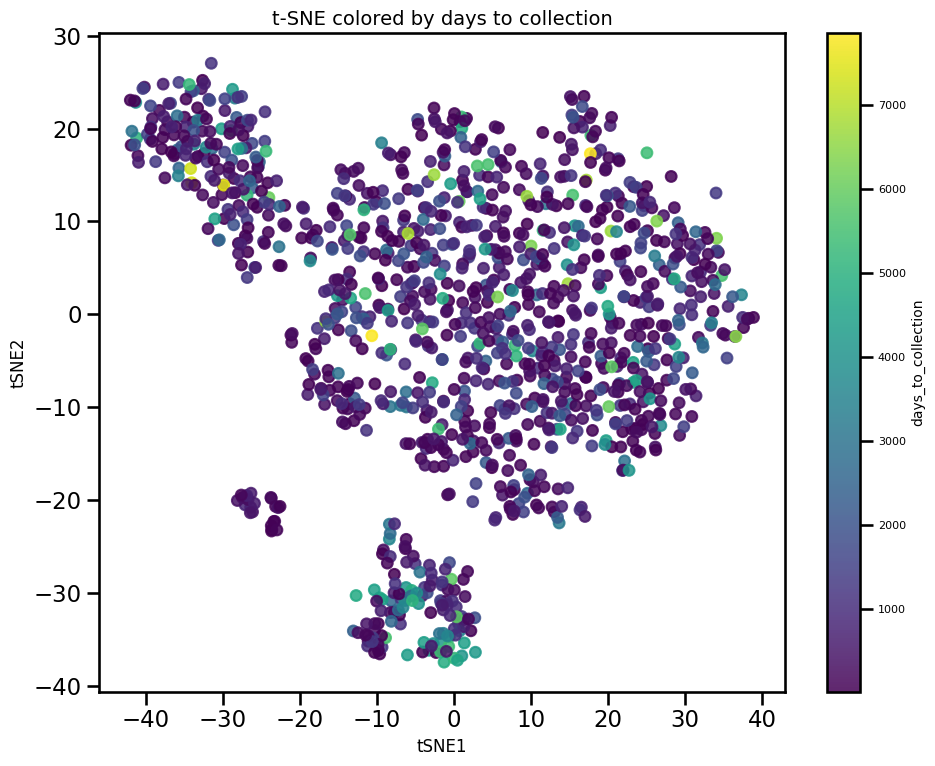

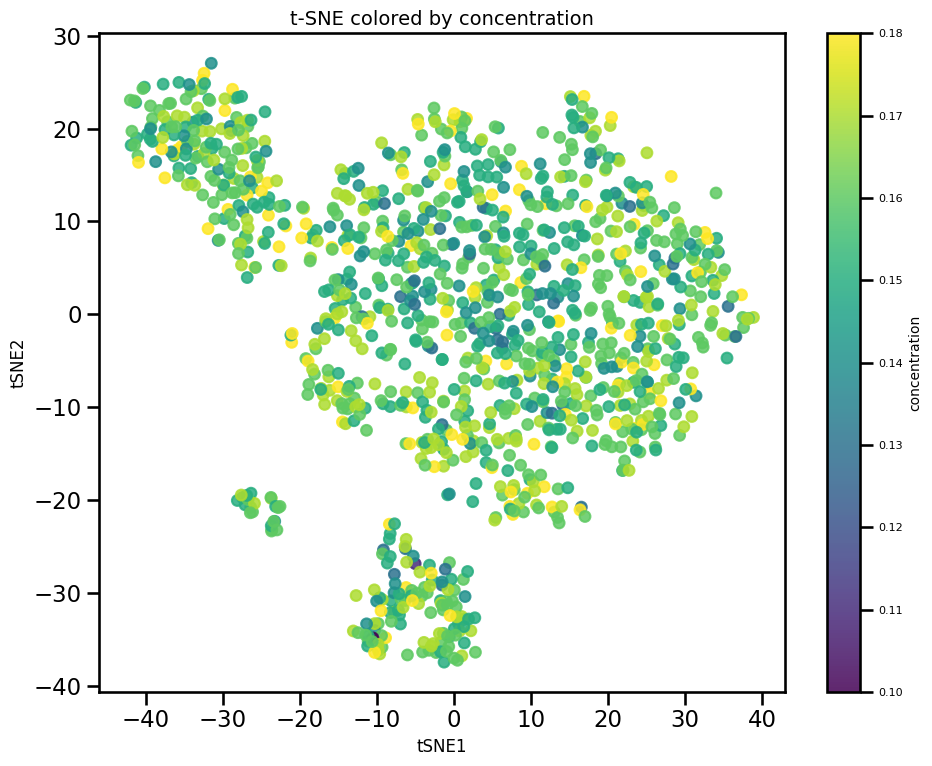

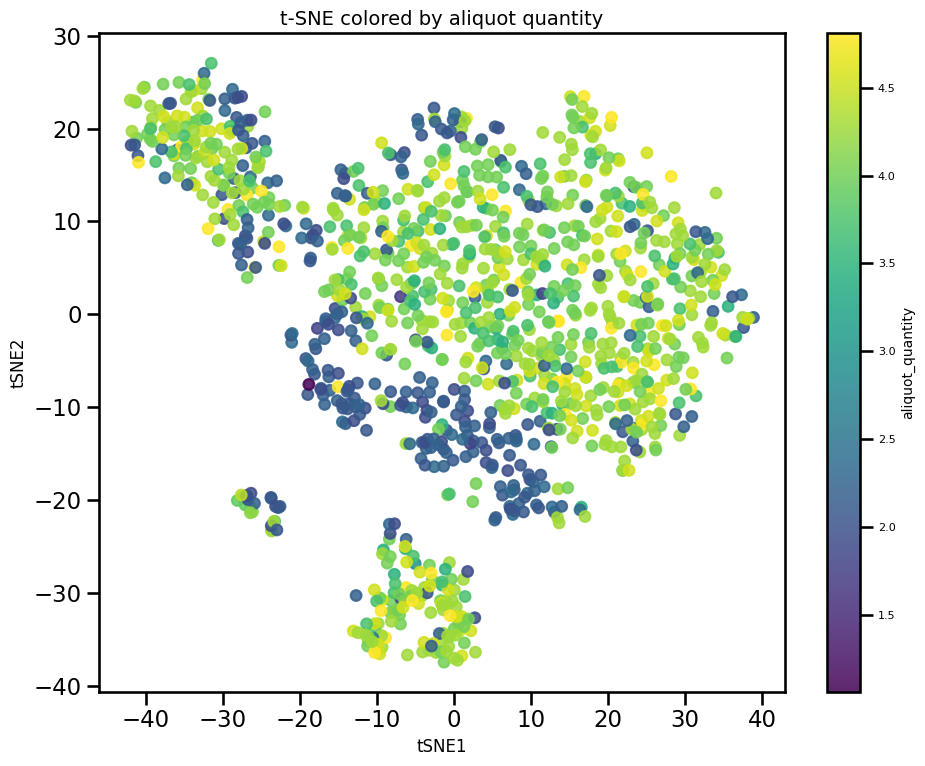

In [7]:
plot_pca_continuous(tsne_with_biospecimen, x="tSNE1", y="tSNE2", color_col="days_to_collection", title="t-SNE colored by days to collection")
plot_pca_continuous(tsne_with_biospecimen, x="tSNE1", y="tSNE2", color_col="concentration", title="t-SNE colored by concentration")
plot_pca_continuous(tsne_with_biospecimen, x="tSNE1", y="tSNE2", color_col="aliquot_quantity", title="t-SNE colored by aliquot quantity")


## UMAP embedding

Reuse the shared `run_umap` helper to produce a 2D UMAP projection from the same PCA space.


In [8]:
from src.dimensionality_reduction import run_umap

umap_df = run_umap(pca_df, n_neighbors=30, min_dist=0.3)
umap_df.head()

/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP1      UMAP2
eddd285e-a946-4e4e-a21d-6e84ed397594  33.536366 -25.804293
4aac7c40-db6b-4648-a82a-7bf397de913a  32.513821 -26.534527
cdc523d2-da82-4a3d-a97e-9745c8a802d1  29.146793 -29.863440
20d25e27-b509-45eb-a734-9b8d6a40c632  31.508160 -25.684738
678ba111-3b01-49b7-83d9-165ef0288a34  33.925880 -25.519741

In [9]:
umap_with_biospecimen = umap_df.join(lookup[biospecimen_fields], how="left")
umap_with_biospecimen.head()


UMAP1      UMAP2    sample_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594  33.536366 -25.804293  Primary Tumor   
4aac7c40-db6b-4648-a82a-7bf397de913a  32.513821 -26.534527  Primary Tumor   
cdc523d2-da82-4a3d-a97e-9745c8a802d1  29.146793 -29.863440  Primary Tumor   
20d25e27-b509-45eb-a734-9b8d6a40c632  31.508160 -25.684738  Primary Tumor   
678ba111-3b01-49b7-83d9-165ef0288a34  33.925880 -25.519741  Primary Tumor   

                                     tumor_descriptor specimen_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594          Primary  Solid Tissue   
4aac7c40-db6b-4648-a82a-7bf397de913a          Primary  Solid Tissue   
cdc523d2-da82-4a3d-a97e-9745c8a802d1          Primary  Solid Tissue   
20d25e27-b509-45eb-a734-9b8d6a40c632          Primary  Solid Tissue   
678ba111-3b01-49b7-83d9-165ef0288a34          Primary  Solid Tissue   

                                     preservation_method tissue_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594             Unknown       Tumor   
4aac7c40-db6b-4648-a82a-7bf397de913a             Unknown       Tumor   
cdc523d2-da82-4a3d-a97e-9745c8a802d1             Unknown       Tumor   
20d25e27-b509-45eb-a734-9b8d6a40c632             Unknown       Tumor   
678ba111-3b01-49b7-83d9-165ef0288a34                 OCT       Tumor   

                                      days_to_collection analyte_type  \
eddd285e-a946-4e4e-a21d-6e84ed397594               193.0          RNA   
4aac7c40-db6b-4648-a82a-7bf397de913a                57.0          RNA   
cdc523d2-da82-4a3d-a97e-9745c8a802d1                70.0          RNA   
20d25e27-b509-45eb-a734-9b8d6a40c632               796.0          RNA   
678ba111-3b01-49b7-83d9-165ef0288a34                80.0          RNA   

                                      aliquot_quantity  aliquot_volume  \
eddd285e-a946-4e4e-a21d-6e84ed397594              4.27            26.7   
4aac7c40-db6b-4648-a82a-7bf397de913a              4.27            26.7   
cdc523d2-da82-4a3d-a97e-9745c8a802d1              1.95            13.0   
20d25e27-b509-45eb-a734-9b8d6a40c632              2.08            13.0   
678ba111-3b01-49b7-83d9-165ef0288a34              4.27            26.7   

                                      concentration  \
eddd285e-a946-4e4e-a21d-6e84ed397594           0.16   
4aac7c40-db6b-4648-a82a-7bf397de913a           0.16   
cdc523d2-da82-4a3d-a97e-9745c8a802d1           0.15   
20d25e27-b509-45eb-a734-9b8d6a40c632           0.16   
678ba111-3b01-49b7-83d9-165ef0288a34           0.16   

                                     normal_tumor_genotype_snp_match  \
eddd285e-a946-4e4e-a21d-6e84ed397594                             Yes   
4aac7c40-db6b-4648-a82a-7bf397de913a                             Yes   
cdc523d2-da82-4a3d-a97e-9745c8a802d1                             Yes   
20d25e27-b509-45eb-a734-9b8d6a40c632                             Yes   
678ba111-3b01-49b7-83d9-165ef0288a34                             Yes   

                                      source_center  
eddd285e-a946-4e4e-a21d-6e84ed397594             23  
4aac7c40-db6b-4648-a82a-7bf397de913a             23  
cdc523d2-da82-4a3d-a97e-9745c8a802d1             23  
20d25e27-b509-45eb-a734-9b8d6a40c632             23  
678ba111-3b01-49b7-83d9-165ef0288a34             23

## UMAP colored by biospecimen categorical labels
### 1. Sample type
### 2. Preservation method
### 3. Tumor descriptor


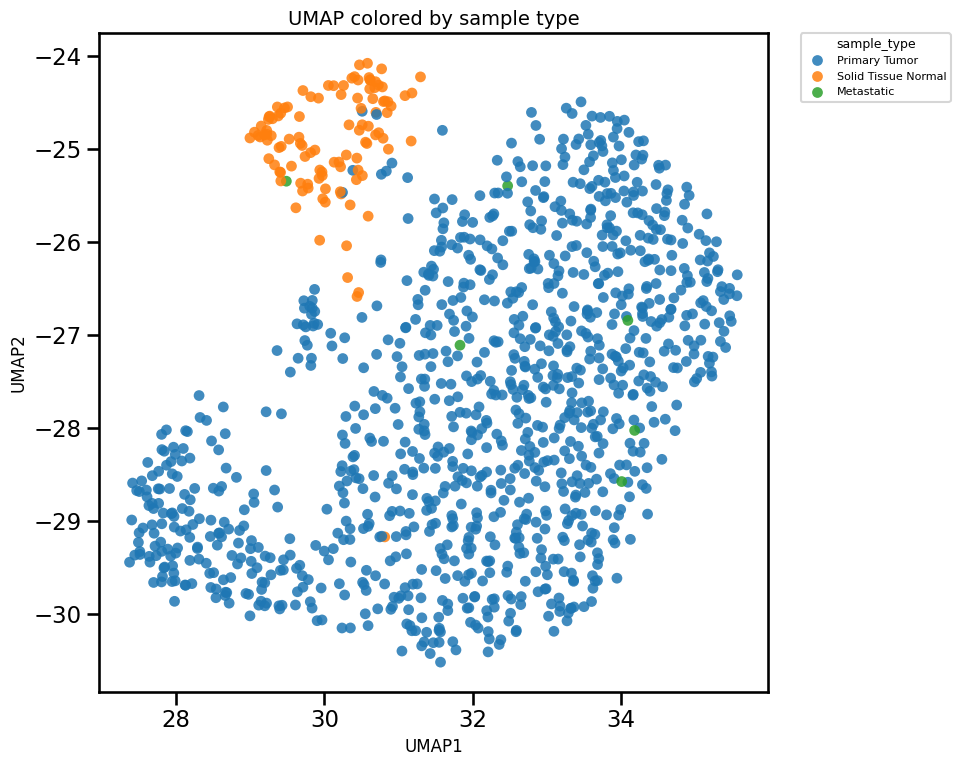

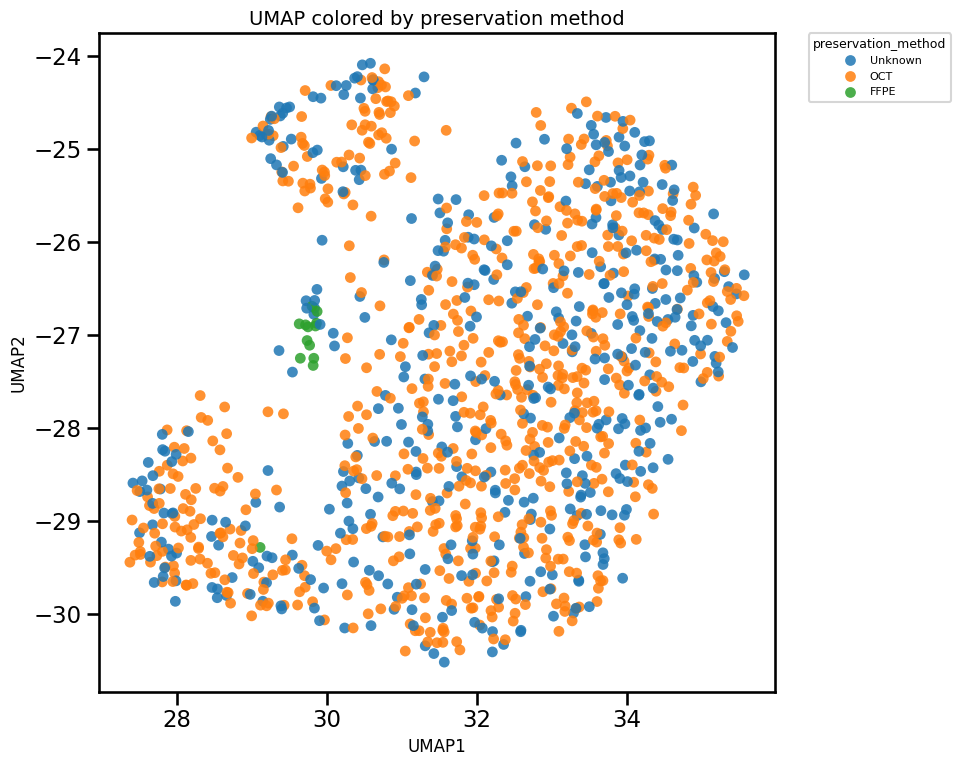

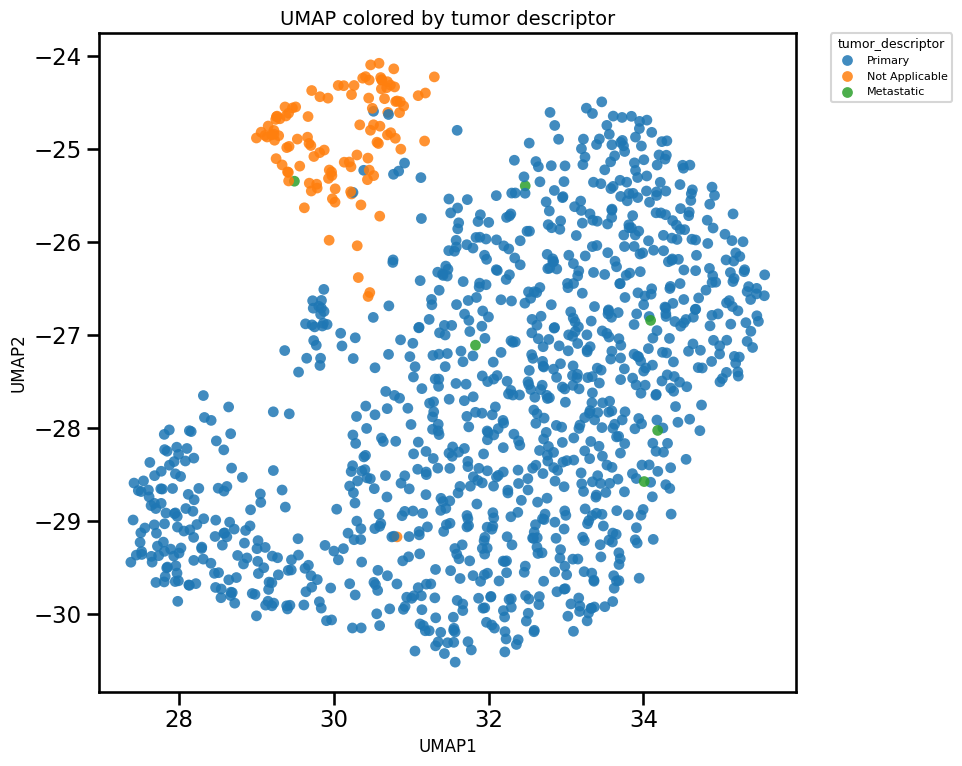

In [10]:
plot_pca_categorical(umap_with_biospecimen, x="UMAP1", y="UMAP2", hue_col="sample_type", title="UMAP colored by sample type")
plot_pca_categorical(umap_with_biospecimen, x="UMAP1", y="UMAP2", hue_col="preservation_method", title="UMAP colored by preservation method")
plot_pca_categorical(umap_with_biospecimen, x="UMAP1", y="UMAP2", hue_col="tumor_descriptor", title="UMAP colored by tumor descriptor")


## UMAP colored by biospecimen continuous metrics
### 1. Days to collection
### 2. RNA concentration
### 3. Aliquot quantity


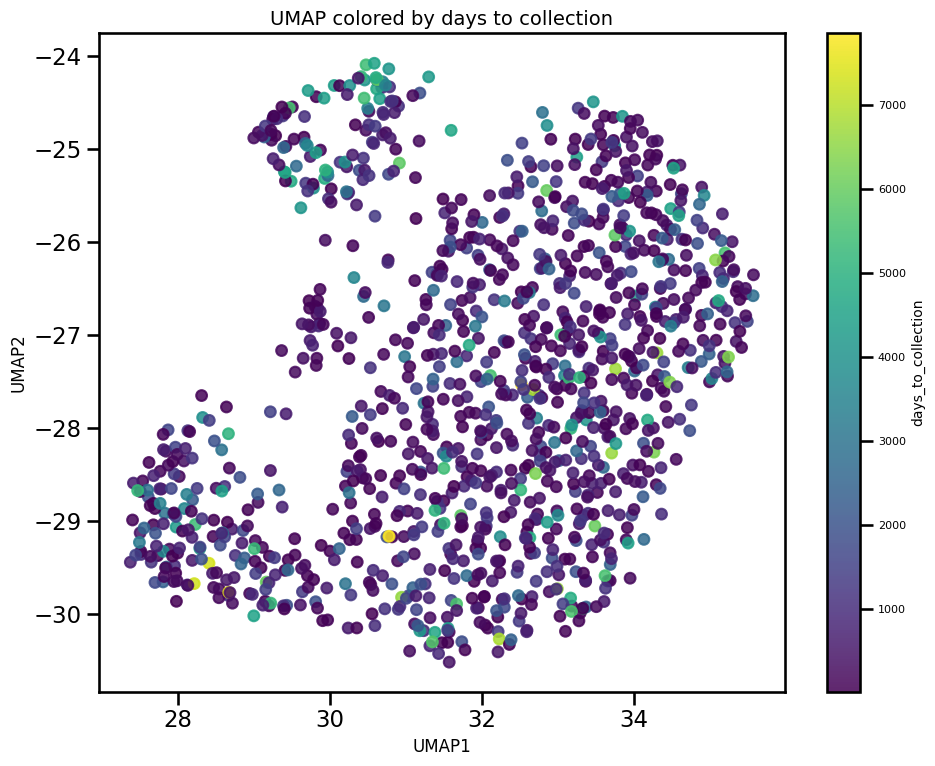

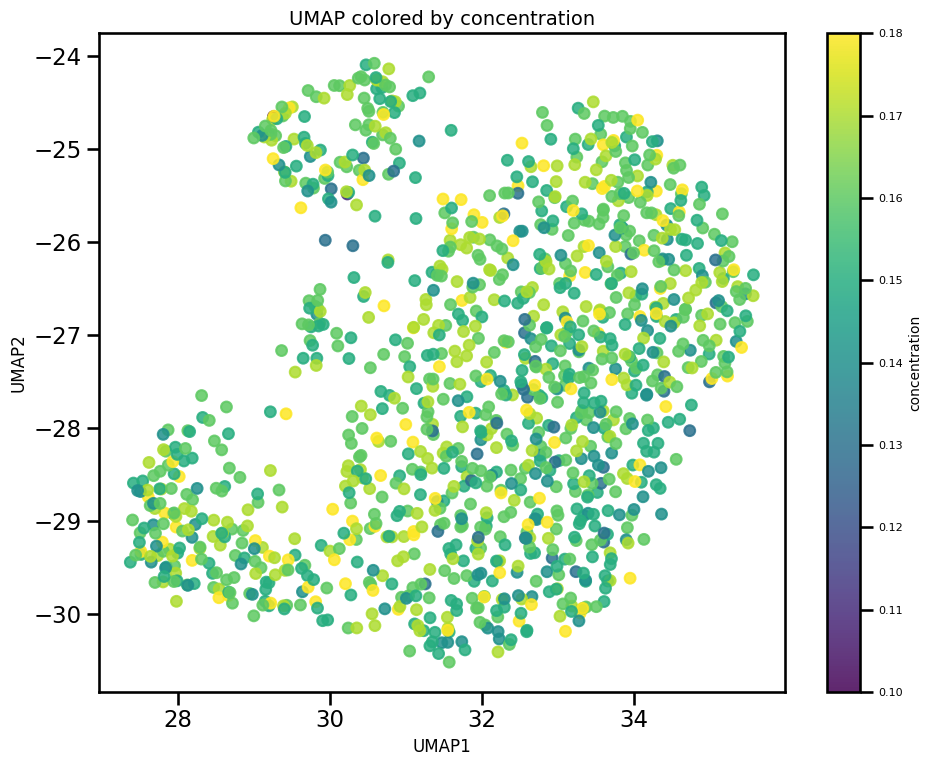

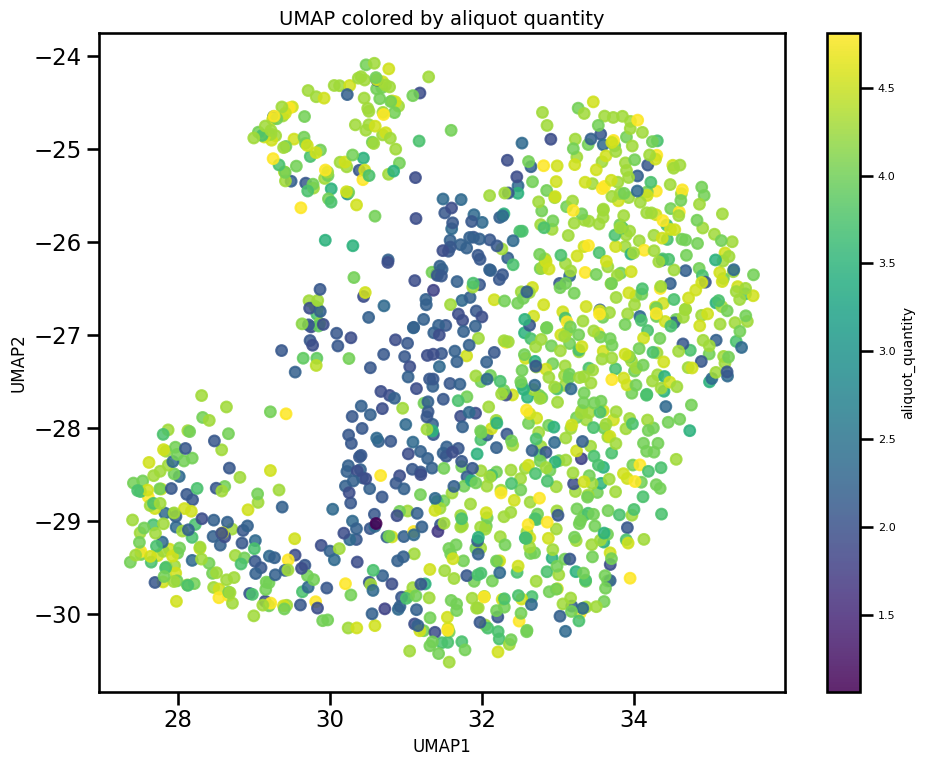

In [11]:
plot_pca_continuous(umap_with_biospecimen, x="UMAP1", y="UMAP2", color_col="days_to_collection", title="UMAP colored by days to collection")
plot_pca_continuous(umap_with_biospecimen, x="UMAP1", y="UMAP2", color_col="concentration", title="UMAP colored by concentration")
plot_pca_continuous(umap_with_biospecimen, x="UMAP1", y="UMAP2", color_col="aliquot_quantity", title="UMAP colored by aliquot quantity")

## Persist embeddings

Save both embeddings for downstream notebooks that perform clustering and clinical association.


In [12]:
tsne_output = PROCESSED_DATA_DIR / "tcga_brca_tsne.tsv.gz"
umap_output = PROCESSED_DATA_DIR / "tcga_brca_umap.tsv.gz"

tsne_df.to_csv(tsne_output, sep="	", compression="gzip")
umap_df.to_csv(umap_output, sep="	", compression="gzip")

tsne_output, umap_output

(PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_tsne.tsv.gz'),
 PosixPath('/Users/lennonmccartney/Desktop/tcga-brca-multiomics-subtyping/data/processed/tcga_brca_umap.tsv.gz'))